In [8]:
# Clone Fedor rep
!git clone https://github.com/ITMO-NSS-team/BAMT.git

Cloning into 'BAMT'...
remote: Enumerating objects: 1421, done.
remote: Counting objects: 100% (864/864), done.
remote: Compressing objects: 100% (634/634), done.
remote: Total 1421 (delta 385), reused 649 (delta 210), pack-reused 557
Receiving objects: 100% (1421/1421), 71.56 MiB | 14.89 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [9]:
import os
os.chdir('/content/BAMT/')
# install req.txt
!pip install -r requirements.txt

In [10]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [11]:
import os
os.chdir('/content/BAMT/')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.calculate_accuracy import calculate_acc
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN

In [12]:
data = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/mandmmsa/main/train.csv', sep = ',')
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,G

In [18]:
columns = ['SalePrice', '1stFlrSF', 'TotalBsmtSF','LotFrontage', 'LotArea', 'GarageArea','GrLivArea', 'BedroomAbvGr', 'MSSubClass', 'Street', 'BedroomAbvGr']
data = data[columns]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
data['SalePrice'] = data['SalePrice'].apply(lambda x: float(x))
data['LotArea'] = data['LotArea'].apply(lambda x: float(x))
data['GarageArea'] = data['GarageArea'].apply(lambda x: float(x))
data['GrLivArea'] = data['GrLivArea'].apply(lambda x: float(x))
data['1stFlrSF'] = data['1stFlrSF'].apply(lambda x: float(x))
data['TotalBsmtSF'] = data['TotalBsmtSF'].apply(lambda x: float(x))
data['MSSubClass'] = data['MSSubClass'].apply(lambda x: float(x))
data['BedroomAbvGr'] = data['BedroomAbvGr'].apply(lambda x: str(x))
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
data

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

,SalePrice,1stFlrSF,TotalBsmtSF,LotFrontage,LotArea,GarageArea,GrLivArea,BedroomAbvGr,BedroomAbvGr,MSSubClass,Street,BedroomAbvGr,BedroomAbvGr
0,208500.0,856.0,856.0,65.0,8450.0,548.0,1710.0,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...,60.0,Pave,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...
1,181500.0,1262.0,1262.0,80.0,9600.0,460.0,1262.0,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...,20.0,Pave,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...
2,223500.0,920.0,920.0,68.0,11250.0,608.0,1786.0,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...,60.0,Pave,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...
3,140000.0,961.0,756.0,60.0,9550.0,642.0,1717.0,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...,70.0,Pave,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...
4,250000.0,1145.0,1145.0,84.0,14260.0,836.0,2198.0,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...,60.0,Pave,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,175000.0,953.0,953.0,62.0,7917.0,460.0,1647.0,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...,60.0,Pave,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...
1197,210000.0,2073.0,1542.0,85.0,13175.0,500.0,2073.0,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...,20.0,Pave,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...
1198,266500.0,1188.0,1152.0,66.0,9042.0,252.0,2340.0,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...,70.0,Pave,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...
1199,142125.0,1078.0,1078.0,68.0,9717.0,240.0,1078.0,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...,20.0,Pave,0 0 3\n1 3\n2 3\n3 ...,0 0 3\n1 3\n2 3\n3 ...


In [ ]:
nodes_type = get_nodes_type(data)
nodes_type

{'SalePrice': 'cont',
 'LotFrontage': 'cont',
 'LotArea': 'cont',
 'GarageArea': 'cont',
 'GrLivArea': 'cont',
 '1stFlrSF': 'cont',
 'BedroomAbvGr': 'disc',
 'TotalBsmtSF': 'cont',
 'MSSubClass': 'cont',
 'Street': 'disc'}

In [ ]:
nodes_sign = get_nodes_sign(data)
nodes_sign

{'SalePrice': 'pos',
 'LotFrontage': 'pos',
 'LotArea': 'pos',
 'GarageArea': 'pos',
 'GrLivArea': 'pos',
 '1stFlrSF': 'pos',
 'TotalBsmtSF': 'pos',
 'MSSubClass': 'pos'}

In [ ]:
coded_data, coder = code_categories(data, 'label', ['Street','BedroomAbvGr'])
discrete_data, coder = discretization(coded_data, 'equal_frequency', ['SalePrice','LotFrontage', 'LotArea', 'GarageArea','GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'MSSubClass'])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:238: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


In [ ]:
bn_HC = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
bn_HC

{'V': ['SalePrice',
  'LotFrontage',
  'LotArea',
  'GarageArea',
  'GrLivArea',
  '1stFlrSF',
  'BedroomAbvGr',
  'TotalBsmtSF',
  'MSSubClass',
  'Street'],
 'E': [['SalePrice', 'GrLivArea'],
  ['SalePrice', 'TotalBsmtSF'],
  ['SalePrice', 'GarageArea'],
  ['LotFrontage', 'LotArea'],
  ['GrLivArea', 'LotFrontage'],
  ['1stFlrSF', 'GrLivArea'],
  ['BedroomAbvGr', 'MSSubClass'],
  ['BedroomAbvGr', 'SalePrice'],
  ['BedroomAbvGr', 'LotFrontage'],
  ['TotalBsmtSF', '1stFlrSF'],
  ['MSSubClass', 'TotalBsmtSF'],
  ['MSSubClass', 'LotFrontage'],
  ['MSSubClass', 'GrLivArea'],
  ['MSSubClass', 'LotArea'],
  ['MSSubClass', 'SalePrice'],
  ['MSSubClass', 'GarageArea'],
  ['Street', 'LotFrontage'],
  ['Street', 'GarageArea'],
  ['Street', 'TotalBsmtSF']]}

In [ ]:
draw_BN(bn_HC, nodes_type, 'houses_bn_HC')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

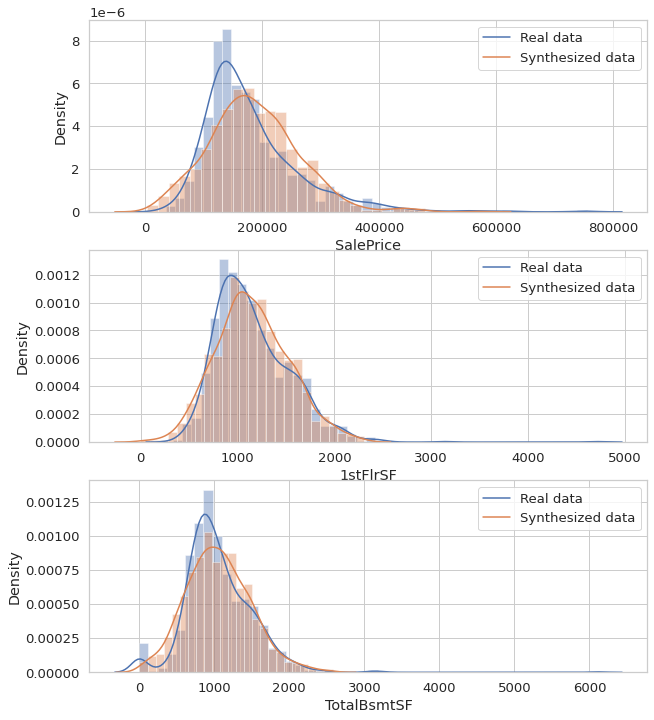

In [ ]:
params_HC = parameter_learning(data, nodes_type, bn_HC, 'simple')
save_structure(bn_HC, 'houses_net_structure_HC')
skel_HC = read_structure('houses_net_structure_HC')
save_params(params_HC, 'houses_net_param_HC')
params_HC = read_params('houses_net_param_HC')
houses_bn_HC = HyBayesianNetwork(skel_HC, params_HC)
synth_df_HC = generate_synthetics(houses_bn_HC, nodes_sign, 'simple', 1200)

sns.set(style      = 'whitegrid',
        font_scale = 1.2,
        rc         = {'figure.figsize':(30, 10)})

fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(data['SalePrice'], ax=ax[0])
sns.distplot(synth_df_HC['SalePrice'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(data['1stFlrSF'], ax=ax[1])
sns.distplot(synth_df_HC['1stFlrSF'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(data['TotalBsmtSF'], ax=ax[2])
sns.distplot(synth_df_HC['TotalBsmtSF'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(houses_bn_HC, data, ['SalePrice', '1stFlrSF', 'TotalBsmtSF'], 'simple')[0:2])

In [ ]:
bn_evo = structure_learning(discrete_data, 'evo', nodes_type, 'MI')
bn_evo

Best metric is 7.768499999999999
Generation num: 0
max_depth: 6, no improvements: 0
spent time: 0.1 min
Best metric is 7.768499999999999
Generation num: 1
max_depth: 6, no improvements: 1
spent time: 0.1 min
Best metric is 7.768499999999999
Generation num: 2
max_depth: 6, no improvements: 2
spent time: 0.2 min
Best metric is 7.609899999999999
Generation num: 3
max_depth: 6, no improvements: 0
spent time: 0.2 min
Best metric is 7.6099
Generation num: 4
max_depth: 6, no improvements: 1
spent time: 0.3 min
Best metric is 7.5843
Generation num: 5
max_depth: 6, no improvements: 0
spent time: 0.4 min
Best metric is 7.584299999999999
Generation num: 6
max_depth: 6, no improvements: 1
spent time: 0.5 min
Best metric is 7.5843
Generation num: 7
max_depth: 6, no improvements: 2
spent time: 0.6 min
Best metric is 7.5843
Generation num: 8
max_depth: 6, no improvements: 3
spent time: 0.6 min
Best metric is 7.5843
Generation num: 9
max_depth: 6, no improvements: 4
spent time: 0.7 min
Best metric is 

{'V': ['SalePrice',
  'LotFrontage',
  'LotArea',
  'GarageArea',
  'GrLivArea',
  '1stFlrSF',
  'BedroomAbvGr',
  'TotalBsmtSF',
  'MSSubClass',
  'Street'],
 'E': [['LotFrontage', 'GrLivArea'],
  ['LotArea', 'GrLivArea'],
  ['1stFlrSF', 'LotArea'],
  ['TotalBsmtSF', 'LotArea'],
  ['Street', 'SalePrice'],
  ['Street', 'TotalBsmtSF'],
  ['MSSubClass', 'SalePrice'],
  ['MSSubClass', 'TotalBsmtSF']]}

In [ ]:
draw_BN(bn_evo, nodes_type, 'houses_bn_evo')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

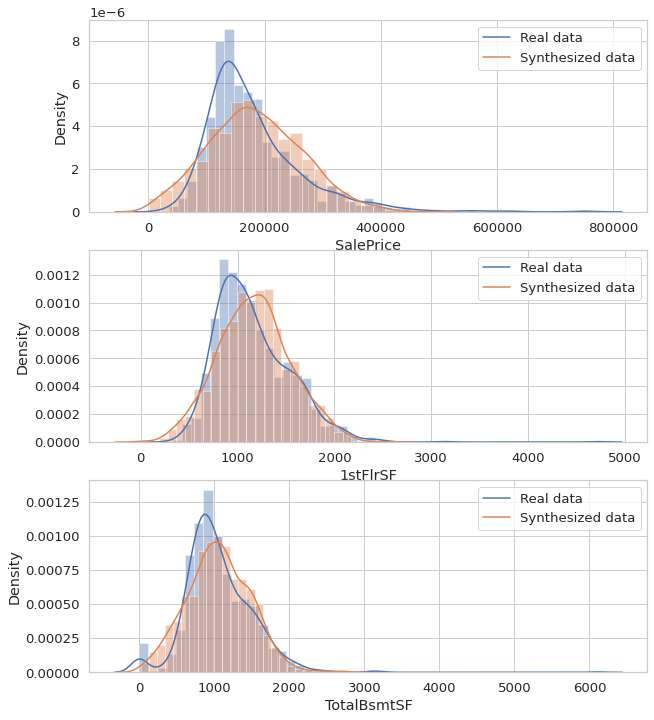

In [ ]:
params_evo = parameter_learning(data, nodes_type, bn_evo, 'simple')
save_structure(bn_evo, 'houses_net_structure_evo')
skel_evo = read_structure('houses_net_structure_evo')
save_params(params_evo, 'houses_net_param_evo')
params_evo = read_params('houses_net_param_evo')
houses_bn_evo = HyBayesianNetwork(skel_evo, params_evo)
synth_df_evo = generate_synthetics(houses_bn_evo, nodes_sign, 'simple', 1200)

sns.set(style      = 'whitegrid',
        font_scale = 1.2,
        rc         = {'figure.figsize':(30, 10)})

fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(data['SalePrice'], ax=ax[0])
sns.distplot(synth_df_evo['SalePrice'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(data['1stFlrSF'], ax=ax[1])
sns.distplot(synth_df_evo['1stFlrSF'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(data['TotalBsmtSF'], ax=ax[2])
sns.distplot(synth_df_evo['TotalBsmtSF'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(houses_bn_evo, data, ['SalePrice', '1stFlrSF', 'TotalBsmtSF'], 'simple')[0:2])

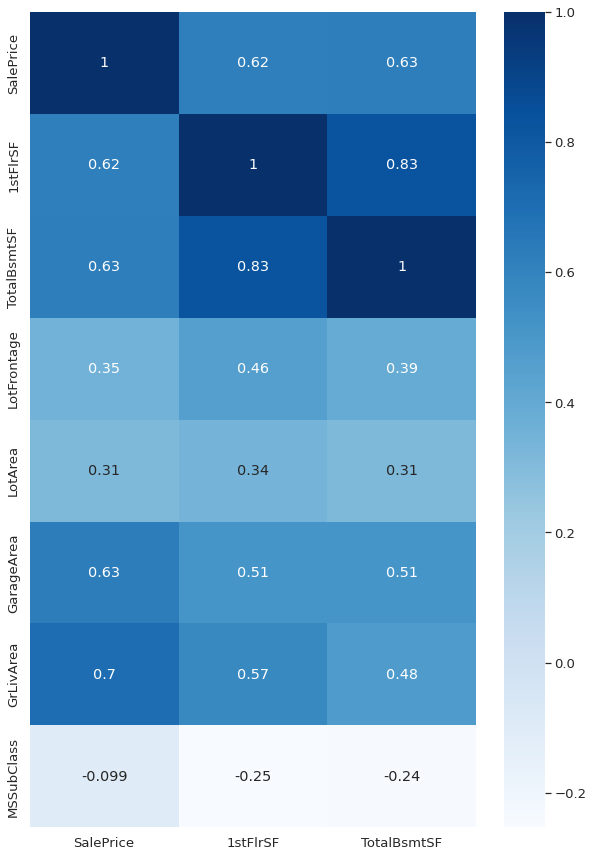

In [21]:
sns.set(style      = 'whitegrid',
        font_scale = 1.2,
        rc         = {'figure.figsize':(10, 15)})


sns.heatmap(data.corr()[['SalePrice', '1stFlrSF', 'TotalBsmtSF']], annot = True, cmap = 'Blues')

bn_corr = dict({'V': ['SalePrice',
  'LotFrontage',
  'LotArea',
  'GarageArea',
  'GrLivArea',
  '1stFlrSF',
  'BedroomAbvGr',
  'TotalBsmtSF',
  'MSSubClass',
  'Street'],
 'E': [['GrLivArea', 'SalePrice'],
  ['TotalBsmtSF', 'SalePrice'],
  ['GarageArea', 'SalePrice'],
  ['GarageArea', 'TotalBsmtSF'],
  ['LotArea', '1stFlrSF'],
  ['LotArea', 'TotalBsmtSF'],
  ['GrLivArea', '1stFlrSF'],
  ['BedroomAbvGr', 'SalePrice'],
  ['1stFlrSF', 'SalePrice'],
  ['GrLivArea', 'TotalBsmtSF'],
  ['LotFrontage', 'TotalBsmtSF'],
  ['LotFrontage', '1stFlrSF'],
  ['Street', 'TotalBsmtSF']]})

#draw_BN(bn_corr, nodes_type, 'houses_bn3')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

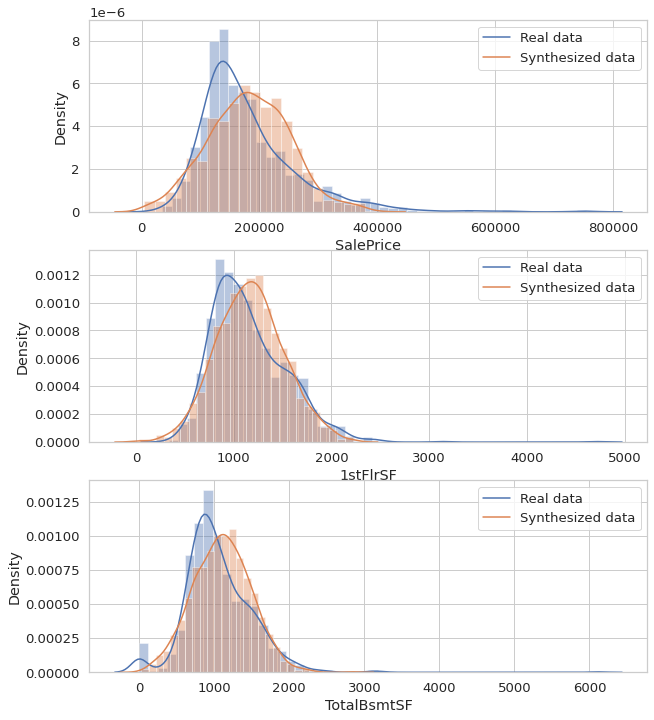

In [ ]:
params_corr = parameter_learning(data, nodes_type, bn_corr, 'simple')
save_structure(bn_corr, 'houses_net_structure_corr')
skel_corr = read_structure('houses_net_structure_corr')
save_params(params_corr, 'houses_net_param_corr')
params_corr = read_params('houses_net_param_corr')
houses_bn_corr = HyBayesianNetwork(skel_corr, params_corr)

synth_df_corr = generate_synthetics(houses_bn_corr, nodes_sign, 'simple', 1200)

sns.set(style      = 'whitegrid',
        font_scale = 1.2,
        rc         = {'figure.figsize':(30, 10)})

fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(data['SalePrice'], ax=ax[0])
sns.distplot(synth_df_corr['SalePrice'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(data['1stFlrSF'], ax=ax[1])
sns.distplot(synth_df_corr['1stFlrSF'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(data['TotalBsmtSF'], ax=ax[2])
sns.distplot(synth_df_corr['TotalBsmtSF'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(houses_bn_corr, data, ['SalePrice', '1stFlrSF', 'TotalBsmtSF'], 'simple')[0:2])